In the last assignment, we explored the role that spacial distribution played in the evolution of different functions over time, but playing with Conway's Game of Life. This approach, though really powerful for its level of simplicity, has some issues, the most obvious being that real human beings dont live in 3x3 lattices where they only interact with their closes neighbors; rather, as we can see just by looking around at human society, some people are more connected than other, some are connected to people far away and closer home, and some are not connected at all.

To model this, a mathematical approach exists too: networks, with their differnt topologies, are able to represent different kinds of interactions between human beings, making for useful tools in the study of how space affects phase transitions.

In this notebook, I will explore the power of the Erdös-Rényi model, a methodology for generating random networks which, when represented as graphs, allow us to precisely model the evolution of systems as diverse as epidemics or social networks, although, due to its random nature, this approximations tend not to be really precise.

First, we get some necessary imports:

In [1]:
import numpy as np                  #Supports common numeric operations
import matplotlib.pyplot as plt     #For graphs
import networkx as nx               #For the creation, manipulation, and study of complex networks.
import csrgraph as cg               #For read-only graphs; we will use it for random walking
from collections import Counter     #Used to count elements in lists
from scipy.stats import chi2_contingency  #For statistical tests

And, now, we generate the adjacency matrix that will be used to define the topology of our Erdös-Rényi network. This model is very simple: we start with n vertices, and, for each vertex pair, we draw a link with probability p under random conditions. Thus, following the pseudocode given by the teacher:

In [2]:
def erdos_renyi(nodes, link_prob):
    x = np.zeros((nodes, nodes),int) #start with n vertices
    for i in range(nodes):
        for j in range(nodes):
            if np.random.uniform(0, 1) < link_prob:
                x[i,j] = x[j,i] = 1
    return(x)

And now, we generate the matrix:

In [3]:
my_matrix = erdos_renyi(100, 0.9)

But, wait... ¿is that it? How do we understand how our network works? How to we interpret the physical significancy of a simple adjacency matrix? Here, I propose to use python's networkx library to plot it, and see how it looks like:

In [4]:
def plot_adjacency(adjacency_matrix):
    gr = nx.from_numpy_matrix(adjacency_matrix)
    mylabels = dict(zip(range(len(adjacency_matrix)), range(len(adjacency_matrix))))
    nx.draw(gr, node_size=200, edge_cmap = "Greys", labels=mylabels, with_labels=True)
    return nx.diameter(gr)

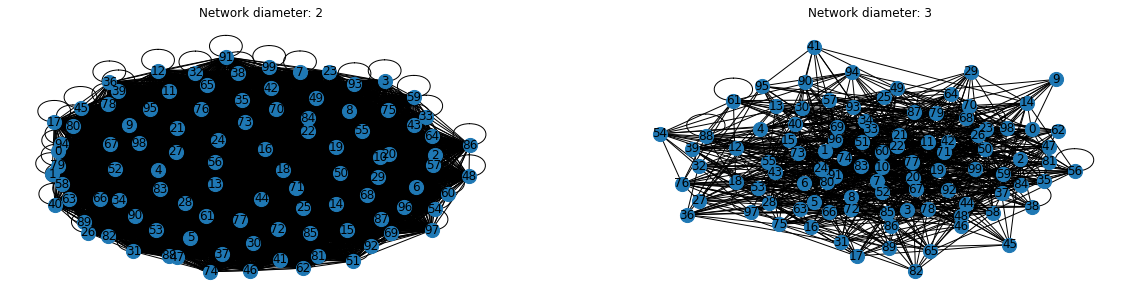

In [5]:
plt.subplots(figsize=(20, 5))
plt.subplot(1, 2, 1)
d = plot_adjacency( erdos_renyi(100, 0.9) ); plt.title(f"Network diameter: {d}")
plt.subplot(1, 2, 2)
d = plot_adjacency( erdos_renyi(100, 0.1) ); plt.title(f"Network diameter: {d}")
plt.show()

As we can see, there are problems with the pre-defined values we chose! 100 elements are so many elements that understanding the network's topology just by looking at it becomes almost impossible; thus, we have decided to use completely different starting values: by using only 35 members and a probability of linkage of 0.1, we can easily understand what is happening:

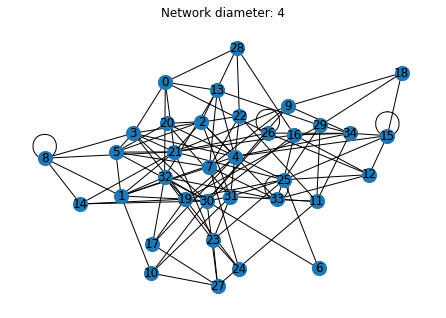

In [6]:
array = np.loadtxt("./adjacency_matrix.csv", delimiter=",")
d = plot_adjacency( array ); plt.title(f"Network diameter: {d}"); plt.show()

(To make the results more reproducible, I have provided with a pre-cooked adjacency matrix; nothing special, but it keeps things consistent)

Another advantage with working with these parameter lies within the concept of **diameter**, the shortest path between the two most distant nodes. In networks with a big number of nodes or of interconnectedness, the diameter rapidly becomes 1 or really close to 1, given how related all nodes are. This can be seen in our first graphs: (depending on how your random number generators behaved), the network diameter either remains 2 or increases to 3; with our approach, the network diameter gets to 4, which is not super high but is more interesting than just 2.

Another potential problem is disconnected networks: ¿what happens if some points appear disconnected from the rest of the matrix? This could be problematic when doing a random walk, so we will only take the biggest component from our graph:

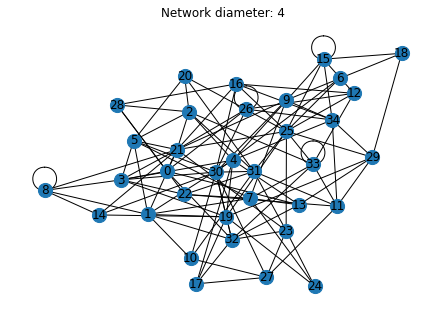

In [7]:
graph = nx.from_numpy_matrix( array ) #Create graph
sub_graph = graph.subgraph( (sorted(nx.connected_components(graph), key=len, reverse=True))[0] ) #Subset after ordering
subarray = nx.to_numpy_matrix( sub_graph ) #Save np.ndarray
d = plot_adjacency( subarray ); plt.title(f"Network diameter: {d}"); plt.show()

(The graph might look a bit different, but its the same as the one before (there were no subnetworks to eliminate); you can, for example, look at the 4 and only 4 auto-connected networks)

Now, to understand how network topology affects information transmission, we will perform a random walk. In this though experiment, we will imagine a traveler, Mariano, that goes through the network one step at a time, seeing what he finds an then moving on. We will record Mariano's position every step on the way, and, when he gets tired (after 100000 steps-phew!), we will save his position and use it to plot an histogram of the frequency (and thus, the probability) of him ending up in a given location. For this, we use the ```csrgraph``` package:

In [8]:
subgraph_cg = cg.csrgraph(sub_graph, threads=12)
walks = subgraph_cg.random_walks(walklen= nx.diameter(sub_graph) + 100, #𝑡 timesteps, with 𝑡 ≫ 𝑑
                                 epochs=100000,  #A very large number of repetitions
                                 start_nodes=np.random.randint(len(subarray)), #Random initial conditions
                                 return_weight=1, #Probability of going back
                                 neighbor_weight=1) #Probability of moving to a new node

And, we extract the last value from the np.ndarray that ```csrgraph``` has generated for us, creating the histogram:

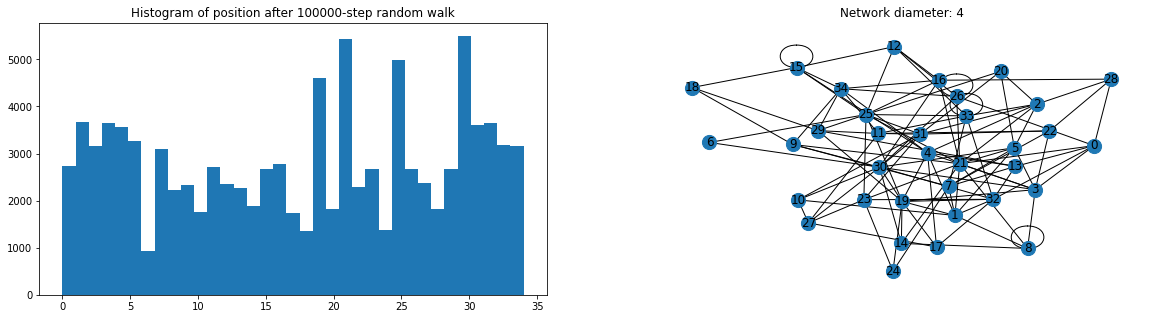

In [9]:
plt.subplots(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(walks[:, -1], bins = 35); plt.title("Histogram of position after 100000-step random walk");
plt.subplot(1, 2, 2)
d = plot_adjacency( subarray ); plt.title(f"Network diameter: {d}")
plt.show()

As we can see, the distribution is **not at all random**; some nodes, such as 25, concentrate lots of final positions, while you will hardly see Mariano in node 18 or, notably, in node 6. This is clearly a more "human" way of representing networks: maybe node 25 is a capital city, concentrating lots of infrastructure to connect it to other dots; and maybe 6 is an isolated village in the north pole, where you would hardly find any human.

For the next part of the assignment, we wish to simulate the spreading of an infection across towns.We will start with all towns, save by one (chosen at random), free of the disease, and one of them with a prevalence of 0.1. Lets see:

In [10]:
disease_conditions = new_disease_conditions = dict(zip(range(len(sub_graph)), np.zeros(len(sub_graph))))
disease_conditions[np.random.randint(len(sub_graph))] = 0.1
incrementer = 1.01; movility = 1; counter = 0

Now, assuming that  each node represents a town and that edges represent mobility patterns across towns, we will proceed to recursively update the incidence among towns, such that any neighbour of an existing town will see its incidence increase by 1% multiplied by a movility factor $m$, in this case, 1 for simplicity. We will keep doing this until all towns reach a prevalence of 1000, and, then, we will stop. Thus:

In [11]:
while any(values < 1000 for  values in disease_conditions.values() ):
    for element in range(len(sub_graph)): #For each of the elemets of the graph
        for neighbor in sub_graph.neighbors(element): #Find its neighbors
            new_disease_conditions[neighbor] = (disease_conditions[neighbor] 
                                               + disease_conditions[element] * movility * incrementer)
    disease_conditions = new_disease_conditions
    counter += 1
print(f"Treshold reached in {counter} generations")

Treshold reached in 3 generations


As we can see, ¡the treshold is reached quite quickly, after less than 5 generations! This seems crazy to me, and is way less than I expected, but I guess it has to do with the high level of interconectedness of the network (remember, its diameter was 4) and with the fact that there are some self-linked nodes. This self-linked nodes are not an error, but rather represent cities with high levels of inner-connectedness; maybe they have a really good public transportation grid, or maybe they represent a small town were everyone knows each other and that just emmerged from some good ol' "fiestas del pueblo". Now, we would like to see how the distribution is going:

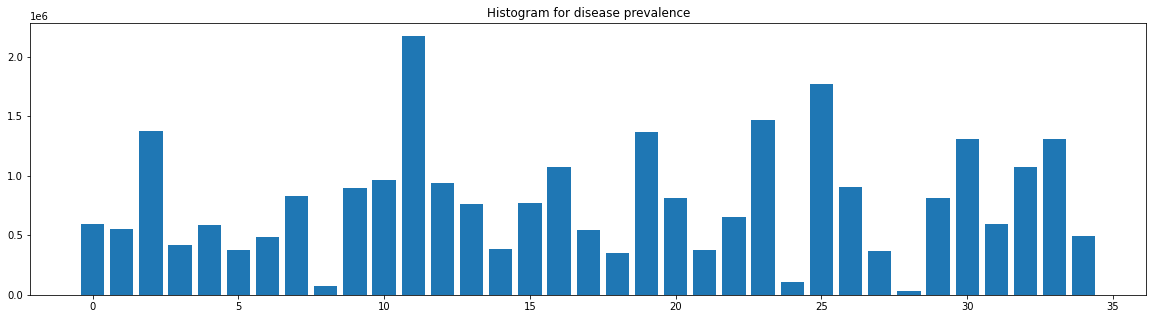

In [12]:
plt.subplots(figsize=(20, 5))
plt.title("Histogram for disease prevalence");
plt.bar(disease_conditions.keys(), disease_conditions.values());

As you can see, the results are staggering! Some nodes, such as #10, present a skyrocket-high incidence rate, while others, such as #7, have just barely reached the treshold, with #27 the most likely culprit as the last node to reach it (and thus, the more overall isolated one). It should be noted that, indeed, #27 is **always** the culprit, at least in the 10 times I have run the simulation; this tells us aa lot about how deterministic the network topology is in the outcome, in this case, of the epidemic.

**Note**: you can see that the bin #35 is empty. This is not an error, but rather a consequence of the programming language chosen: python starts indexing at 0, and, if you look at the initial graphs, there has never been a node #35

Now, we would like to see how this parameters change if we modify the movility factor from 1 to 0.1, and, later, to 0.01. Lets thus define a helper function:

In [13]:
def helper_function(movility, incrementer, seed):
    disease_conditions = new_disease_conditions = dict(zip(range(len(sub_graph)), np.zeros(len(sub_graph))))
    disease_conditions[np.random.randint(len(sub_graph))] = seed; counter = 0
    while any(values < 1000 for  values in disease_conditions.values() ):
        for element in range(len(sub_graph)): #For each of the elemets of the graph
            for neighbor in sub_graph.neighbors(element): #Find its neighbors
                new_disease_conditions[neighbor] = (disease_conditions[neighbor] 
                                                   + disease_conditions[element] * movility * incrementer)
        disease_conditions = new_disease_conditions
        counter += 1
    plt.title(f"Histogram for disease prevalence after {counter} generations, with movility = {movility}");
    plt.bar(disease_conditions.keys(), disease_conditions.values());

And we plot:

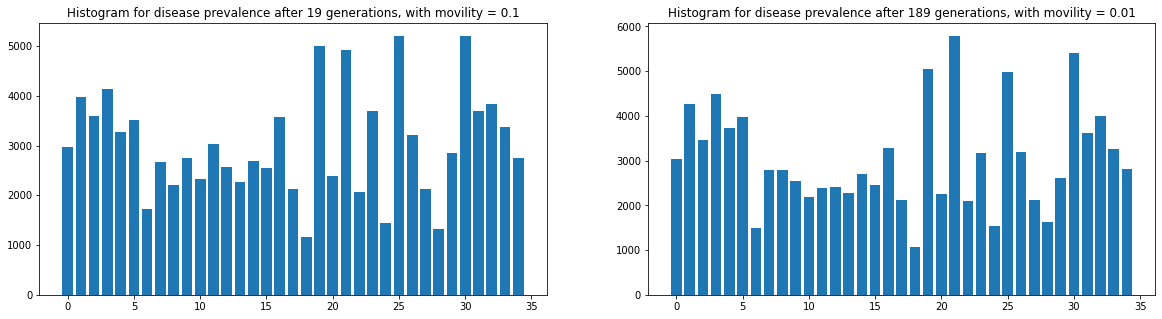

In [14]:
plt.subplots(figsize=(20, 5))
plt.subplot(1, 2, 1)
helper_function(0.1, 1.01, 0.1)
plt.subplot(1, 2, 2)
helper_function(0.01, 1.01, 0.1)
plt.show()

As we can see, there is really no big difference between the first and the second graphs, other that one takes way more steps to reach our desired treshold than the other. This seems to support the theory I developed earlier (and that, to be quite frank, I am not sure if its the case or not) that it is the **network topology** that is deterministic towards a result, and not the initial conditions (up to a certain extent, obviously).

Finally, we are interested in which measure of network centrality (degree or eigenvector centrality) correlates the best with the distribution of probability (in the RW) or prevalence (in the disease spreading) across nodes at the end of the simulation. This should be easy to calculate!

In [15]:
a = dict(Counter(walks[:, -1])) #Some work is needed to count and order the list of values in walks[:, -1]
a_list = sorted(dict(Counter(walks[:, -1]))) #Thanks to stack overflow for the code :D
probability = list(dict(sorted(a.items(), key=lambda pair: a_list.index(pair[0]))).values())

In [16]:
#For eigenvector centrality and prevalence 
s, p, f, d = chi2_contingency([list(nx.eigenvector_centrality(sub_graph).values()), list(disease_conditions.values())])
print(f"The Chi Squared test found a p-value of {p} under {f} degrees of freedom [E-Pre]")
#For eigenvector centrality and probability
s, p, f, d = chi2_contingency([list(nx.eigenvector_centrality(sub_graph).values()), probability])
print(f"The Chi Squared test found a p-value of {p} under {f} degrees of freedom [E-Pro]")
#For degree and prevalence 
s, p, f, d = chi2_contingency([list(dict(sub_graph.degree).values()), list(disease_conditions.values())])
print(f"The Chi Squared test found a p-value of {p} under {f} degrees of freedom [D-Pre]")
#For degree and probability
s, p, f, d = chi2_contingency([list(dict(sub_graph.degree).values()), probability])
print(f"The Chi Squared test found a p-value of {p} under {f} degrees of freedom [D-Pro]")

The Chi Squared test found a p-value of 0.9999999997346068 under 34 degrees of freedom [E-Pre]
The Chi Squared test found a p-value of 1.0 under 34 degrees of freedom [E-Pro]
The Chi Squared test found a p-value of 3.867403696778631e-22 under 34 degrees of freedom [D-Pre]
The Chi Squared test found a p-value of 1.0 under 34 degrees of freedom [D-Pro]


Curiously enough, it seems like **eigenvector centrality** is a really, really good predictor of outcomes both in prevalence and in probability (although here I used raw occurrence instead of probability since, for a chi-squared test, they are interchangeable). This makes sense: eigenvector centrality is a measure of the influence of a node in a network, and, the more influential a node is, the more likely it will have travellers (@Mariano), or, if an epidemic breaks out, of getting infected the first and suffering it the most.

For **degree**, a weird thing happens: it is a really good predictor of probability, but a really, really bad predictor of prevalence. This, I am guessing, will most likely have to do with self-attached nodes: since they are autoconnected, they will have an artificially high degree value, which might bode well for probability of appearance, since it would just mean Mariano spends more time in the node; but might mess up with probability, as these networks, I theorized, act as "concentrators" and "seeders" of the virus, just as Wuhan's market did with CoViD.

In any case, these super close correlations support my hypothesis that **it is network topology, and not initial conditions, that determine evolution of events in the network**. This, of course, should be further explored, but, if confirmed, would provide a new way to look at issues such as racism and segregation [[see this related webpage](https://ncase.me/polygons/)], which, if network configuration is so relevant, would proof much more difficult to fix.